## Full data

In [1]:
import os
import cv2
import sys
import random
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import rasterio 
#from skimage.transform import rescale, resize

from random import seed
import scipy
from glob import glob
import matplotlib.pyplot as plt
from rasterio.windows import Window
import math

from keras.optimizers import SGD, Adam, RMSprop
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D
from keras import layers
from keras.models import Model
import tensorflow as tf

#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## 3 channels

'0_0.tif', '0_1.tif', '0_2.tif', '0_3.tif', '1_0.tif', '1_1.tif', '1_2.tif', '1_3.tif', '1_4.tif', '2_1.tif', '2_2.tif', '2_3.tif', '2_4.tif', '2_5.tif', '2_6.tif', '2_7.tif', '2_8.tif', '3_1.tif', '3_2.tif', '3_3.tif', '3_4.tif', '3_5.tif', '3_6.tif', '3_7.tif', '3_8.tif', '3_9.tif', '4_1.tif', '4_2.tif', '4_3.tif', '4_4.tif', '4_5.tif', '4_6.tif', '4_7.tif', '4_8.tif', '4_9.tif', '5_1.tif', '5_2.tif', '5_3.tif', '5_4.tif', '5_5.tif', '5_6.tif', '5_7.tif', '5_8.tif', '6_3.tif', '6_4.tif', '6_5.tif', '6_6.tif', '6_7.tif', '7_3.tif', '7_4.tif', '7_5.tif','7_6.tif', '7_7.tif', '8_5.tif', '8_6.tif', '9_5.tif', '9_6.tif'

### Split on test, train, validation

In [2]:
os.listdir('/home/user/data/EO_Browser_images')

['.ipynb_checkpoints', '3', '2', '0', '1']

In [3]:
seed(6)
aoi_list = ['0_0.tif', '0_1.tif', '0_2.tif', '0_3.tif', '1_0.tif', '1_1.tif', '1_2.tif', '1_3.tif', '1_4.tif', '2_1.tif', '2_2.tif', '2_3.tif', '2_4.tif', '2_5.tif', '2_6.tif', '2_7.tif', '2_8.tif', '3_1.tif', '3_2.tif', '3_3.tif', '3_4.tif', '3_5.tif', '3_6.tif', '3_7.tif', '3_8.tif', '3_9.tif', '4_1.tif', '4_2.tif', '4_3.tif', '4_4.tif', '4_5.tif', '4_6.tif', '4_7.tif', '4_8.tif', '4_9.tif', '5_1.tif', '5_2.tif', '5_3.tif', '5_4.tif', '5_5.tif', '5_6.tif', '5_7.tif', '5_8.tif', '6_3.tif', '6_4.tif', '6_5.tif', '6_6.tif', '6_7.tif', '7_3.tif', '7_4.tif', '7_5.tif','7_6.tif', '7_7.tif', '8_5.tif', '8_6.tif', '9_5.tif', '9_6.tif']
aoi_list = [k.split('.')[0] for k in aoi_list]
train_list_split = random.sample(aoi_list, k=41)
test_list_split = random.sample([k for k in aoi_list if k not in train_list_split], k=8)
val_list_split = random.sample([k for k in aoi_list if k not in test_list_split and k not in train_list_split], k=8)

print(train_list_split)
print(test_list_split)
print(val_list_split)

train_img_list = []
test_img_list = []
val_img_list = []

# Mandrog
for folder in [0, 1]:
    for file_name in os.listdir('/home/user/data/EO_Browser_images/{}'.format(folder)):
        if file_name[:3] in train_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in train_img_list:
            train_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]
        elif file_name[:3] in test_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in test_img_list:
            test_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]
        elif file_name[:3] in val_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in val_img_list:
            val_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]

['7_5', '5_2', '7_7', '1_1', '4_6', '7_3', '2_8', '0_2', '0_0', '2_1', '5_8', '5_3', '4_5', '3_7', '3_4', '0_1', '3_1', '8_6', '2_4', '4_1', '4_9', '9_5', '1_2', '5_4', '9_6', '8_5', '4_2', '2_5', '2_2', '7_4', '2_3', '3_9', '4_4', '1_4', '2_6', '0_3', '5_1', '6_7', '3_5', '5_7', '6_6']
['5_6', '4_3', '6_4', '3_2', '4_7', '4_8', '7_6', '1_0']
['5_5', '2_7', '3_8', '3_6', '3_3', '6_3', '1_3', '6_5']


## Compute statistics

In [5]:
aspen_stat = 0
birch_stat = 0
pine_stat = 0
spruce_stat = 0

for dse_path in train_img_list:
    aspen_stat += np.sum(tiff.imread(dse_path + '_class_Os.tif')>0.5)
    birch_stat += np.sum(tiff.imread(dse_path + '_class_B.tif')>0.5)
    pine_stat += np.sum(tiff.imread(dse_path + '_class_S.tif')>0.5)
    spruce_stat += np.sum(tiff.imread(dse_path + '_class_E.tif')>0.5)

In [6]:
print('aspen: ', aspen_stat, round(aspen_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('birch: ', birch_stat, round(birch_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('pine: ', pine_stat, round(pine_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('spruce: ', spruce_stat, round(spruce_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
print('deciduous: ', aspen_stat+birch_stat, round((aspen_stat+birch_stat)/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('conifer: ', pine_stat+spruce_stat, round((pine_stat+spruce_stat)/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))

aspen:  886632 0.172
birch:  1385786 0.268
pine:  993156 0.192
spruce:  1901716 0.368
~~~~~~~~~~~~~~~~~~~~~~~~~
deciduous:  2272418 0.44
conifer:  2894872 0.56


### Set path to data

In [4]:
IMG_ROW=IMG_COL=64
IMG_CHANNEL=13

age_flag = True

In [5]:
def get_img_mask_array(imgpath, num_channels=13, num_classes=2, class_0=['S'], class_1=['E']):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    rnd_x = random.randint(0,size_x -  IMG_ROW - 1)
    rnd_y = random.randint(0,size_y - IMG_COL - 1)
    window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
    
    img = np.ones((IMG_ROW, IMG_COL, num_channels), dtype=np.float)
    with rasterio.open(imgpath+ '_channel_01.tif') as src:
        img[:,:,0] = src.read(window=window)
    
    mask_0 = np.zeros((1, IMG_ROW, IMG_COL))
    for cl_name in class_0:
        with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
            mask_0 += src.read(window=window).astype(np.float)
    mask_0 = mask_0 > 0.5
    
    mask_1 = np.zeros((1, IMG_ROW, IMG_COL))
    for cl_name in class_1:
        with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
            mask_1 += src.read(window=window).astype(np.float)
    mask_1 = mask_1 > 0.5
                
    # remove black area
    while np.sum(mask_0+mask_1) < IMG_ROW*IMG_COL / 10 or np.count_nonzero(img[:,:,0]) < IMG_ROW*IMG_COL*3/5.:
        rnd_x = random.randrange(0,size_x -  IMG_ROW - 1) 
        rnd_y = random.randrange(0,size_y - IMG_COL - 1)
        window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
        with rasterio.open(imgpath+ '_channel_01.tif') as src:
            img[:,:,0] = src.read(window=window)
        parent_mask = np.zeros((1, IMG_ROW, IMG_COL))
        mask_0 = np.zeros((1, IMG_ROW, IMG_COL))
        for cl_name in class_0:
            with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
                mask_0 += src.read(window=window).astype(np.float)
        mask_0 = mask_0 > 0.5

        mask_1 = np.zeros((1, IMG_ROW, IMG_COL))
        for cl_name in class_1:
            with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
                mask_1 += src.read(window=window).astype(np.float)
        mask_1 = mask_1 > 0.5

            
    for i in range(1, num_channels-1-age_flag):
        i_ch =  i + 1
        if i < 9:
            i_ch = '0' + str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            img[:,:,i] = src.read(window=window)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        img[:,:,-1-age_flag] = src.read(window=window)  

    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(window=window).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)
 
    mask = np.ones((IMG_ROW, IMG_COL, num_classes)) 
    mask[:,:,0] = mask_0  
    mask[:,:,1] = mask_1 
 
    return np.asarray(img), np.asarray(mask)  

In [7]:
img_tmp, mask_tmp = get_img_mask_array(train_img_list[0], num_channels=13+age_flag)

Text(0.5,1,'9')

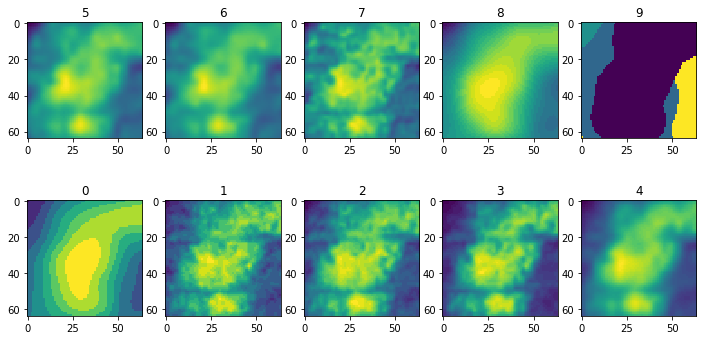

In [8]:
fig = plt.figure(figsize = (12,12))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(img_tmp[:,:,0])
a.set_title('0')
a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(img_tmp[:,:,1])
a.set_title('1')
a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(img_tmp[:,:,2])
a.set_title('2')
a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(img_tmp[:,:,3])
a.set_title('3')
a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(img_tmp[:,:,4])
a.set_title('4')

a = fig.add_subplot(2, 5, 1)
imgplot = plt.imshow(img_tmp[:,:,5])
a.set_title('5')
a = fig.add_subplot(2, 5, 2)
imgplot = plt.imshow(img_tmp[:,:,6])
a.set_title('6')
a = fig.add_subplot(2, 5, 3)
imgplot = plt.imshow(img_tmp[:,:,7])
a.set_title('7')
a = fig.add_subplot(2, 5, 4)
imgplot = plt.imshow(img_tmp[:,:,8])
a.set_title('8')
a = fig.add_subplot(2, 5, 5)
imgplot = plt.imshow(img_tmp[:,:,-1])
a.set_title('9')

In [6]:
def train_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            rnd_id=random.randint(0,len(train_img_list)-1)
            img,mask=get_img_mask_array(train_img_list[rnd_id], num_channels, class_0=class_0, class_1=class_1)
            
            imgarr.append(img)
            maskarr.append(mask)
            
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[]

In [7]:
def val_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            rnd_id=random.randint(0,len(val_img_list)-1)
            img,mask=get_img_mask_array(val_img_list[rnd_id], num_channels, class_0=class_0, class_1=class_1)
            
            imgarr.append(img)
            maskarr.append(mask)
            
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[]

In [8]:
def weighted_categorical_crossentropy(weights):
    def loss(target,output,from_logits=False):
        output /= tf.reduce_sum(output,
                                len(output.get_shape()) - 1,
                                True)
        non_zero_pixels = tf.reduce_sum(target, axis=-1)
        _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        weighted_losses = target * tf.log(output) * weights
        return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1) * (IMG_ROW*IMG_COL*batch_size) / K.sum(non_zero_pixels)
  
    return loss
    
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    weights_list = np.zeros((len(keys)))
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        #score = mu*total/float(labels_dict[key])
        class_weight[key] = score if score > 1.0 else 1.0
        weights_list[sorted(keys).index(key)] = class_weight[key]
    return class_weight, weights_list

In [21]:
labels_dict = {'0': 192, '1': 368}
class_weight, weights_list = create_class_weight(labels_dict, mu=0.8)
weights_list

array([1., 1.])

aspen:  886632 0.172

birch:  1385786 0.268

pine:  993156 0.192

spruce:  1901716 0.368

~~~~~~~~~~~~~~~~~~~~~~~~~

deciduous:  2272418 0.44

conifer:  2894872 0.56

## Conifer / deciduous

In [22]:
weights_list = [ 1., 1.]

In [25]:
num_channels = 13+age_flag
batch_size = 64
class_0 = ['B', 'Os']
class_1 = ['E', 'S']
model_name = 'cd_final_exp'
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
loss =  weighted_categorical_crossentropy(weights_list)  
opt = Adam(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [26]:
save_dir = '/home/user/data/example/data/Forestry_inventory/conifer_deciduous/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True)
]

history=model.fit_generator(train_gen(batch_size),epochs=20, #35, 25 20
                           steps_per_epoch=100,
                           validation_data=val_gen(batch_size),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=30)

Epoch 1/20
100/100 [==============================] - 197s 2s/step - loss: 0.3918 - loss_1: 0.3918 - val_loss: 0.3602 - val_loss_1: 0.3602

Epoch 00001: val_loss improved from inf to 0.36016, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/cd_final_exp.h5

Epoch 00001: val_loss improved from inf to 0.36016, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/cd_final_exp.hdf5
Epoch 2/20
100/100 [==============================] - 166s 2s/step - loss: 0.3345 - loss_1: 0.3345 - val_loss: 0.3511 - val_loss_1: 0.3511

Epoch 00002: val_loss improved from 0.36016 to 0.35108, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/cd_final_exp.h5

Epoch 00002: val_loss improved from 0.36016 to 0.35108, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/cd_final_exp.hdf5
Epoch 3/20
100/100 [==============================] - 177s 2s/step - loss: 0.3220 - loss_1: 0.3220 - val_l

In [29]:
metric_4cl(model, num_cl = 2, class_0=class_0, class_1=class_1)

0 : precision  0.90512  recall  0.91966  f1  0.91233
 
1 : precision  0.89137  recall  0.81902  f1  0.85367
 


In [30]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


## Conifer

In [31]:
weights_list = [ 1., 2.]

In [32]:
num_channels = 13+age_flag
batch_size = 64
model_name = 'con_final_exp'
class_0 = ['E']
class_1 = ['S']
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
loss =  weighted_categorical_crossentropy(weights_list)  
opt = Adam(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
save_dir = '/home/user/data/example/data/Forestry_inventory/conifer_deciduous/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True)
]

history=model.fit_generator(train_gen(batch_size),epochs=20, #35, 25 20
                           steps_per_epoch=100,
                           validation_data=val_gen(batch_size),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=30)

Epoch 1/20
100/100 [==============================] - 220s 2s/step - loss: 0.4168 - loss_1: 0.4168 - val_loss: 0.4402 - val_loss_1: 0.4402

Epoch 00001: val_loss improved from inf to 0.44019, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/con_final_exp.h5

Epoch 00001: val_loss improved from inf to 0.44019, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/con_final_exp.hdf5
Epoch 2/20
100/100 [==============================] - 182s 2s/step - loss: 0.3435 - loss_1: 0.3435 - val_loss: 0.4652 - val_loss_1: 0.4652

Epoch 00002: val_loss did not improve from 0.44019

Epoch 00002: val_loss did not improve from 0.44019
Epoch 3/20
100/100 [==============================] - 200s 2s/step - loss: 0.3117 - loss_1: 0.3117 - val_loss: 1.0066 - val_loss_1: 1.0066

Epoch 00003: val_loss did not improve from 0.44019

Epoch 00003: val_loss did not improve from 0.44019
Epoch 4/20
100/100 [==============================] - 202s 2s/step - 

In [ ]:
metric_4cl(model, num_cl = 2, class_0=class_0, class_1=class_1)

In [ ]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

In [42]:
model_name = 'con_final_exp'
class_0 = ['E']
class_1 = ['S']

json_file = open('/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}.h5".format(model_name))  

metric_4cl(model, num_cl = 2, class_0=class_0, class_1=class_1)

0 : precision  0.94426  recall  0.90419  f1  0.92379
 
1 : precision  0.88918  recall  0.93508  f1  0.91155
 


## Deciduous

In [9]:
weights_list = [ 1.5, 1.]

In [10]:
val_img_list_tmp  = []
for i in range(len(val_img_list)):
    tmp = (tiff.imread(val_img_list[i] + '_class_B.tif')>0.5)
    tmp += (tiff.imread(val_img_list[i] + '_class_Os.tif')>0.5)
    if np.sum(tmp) > 7000:
        #print(np.sum(tmp))
        val_img_list_tmp += [val_img_list[i]]
        
train_img_list_tmp  = []
for i in range(len(train_img_list)):
    tmp = (tiff.imread(train_img_list[i] + '_class_B.tif')>0.5)
    tmp += (tiff.imread(train_img_list[i] + '_class_Os.tif')>0.5)
    if np.sum(tmp) > 7000:
        #print(np.sum(tmp))
        train_img_list_tmp += [train_img_list[i]]

print(len(train_img_list_tmp), len(train_img_list))
train_img_list = train_img_list_tmp
val_img_list = val_img_list_tmp

72 82


In [11]:
num_channels = 13+age_flag
batch_size = 64
class_0 = ['Os']
class_1 = ['B']
model_name = 'dec_final_exp'
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
loss =  weighted_categorical_crossentropy(weights_list)  
opt = Adam(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [12]:
save_dir = '/home/user/data/example/data/Forestry_inventory/conifer_deciduous/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True)
]

history=model.fit_generator(train_gen(batch_size),epochs=20, #35, 25 20
                           steps_per_epoch=100,
                           validation_data=val_gen(batch_size),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=30)

Epoch 1/20
100/100 [==============================] - 201s 2s/step - loss: 0.6319 - loss_1: 0.6319 - val_loss: 1.1011 - val_loss_1: 1.1011

Epoch 00001: val_loss improved from inf to 1.10106, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/dec_final_exp.h5

Epoch 00001: val_loss improved from inf to 1.10106, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/dec_final_exp.hdf5
Epoch 2/20
100/100 [==============================] - 177s 2s/step - loss: 0.5582 - loss_1: 0.5582 - val_loss: 0.8093 - val_loss_1: 0.8093

Epoch 00002: val_loss improved from 1.10106 to 0.80927, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/dec_final_exp.h5

Epoch 00002: val_loss improved from 1.10106 to 0.80927, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/dec_final_exp.hdf5
Epoch 3/20
100/100 [==============================] - 187s 2s/step - loss: 0.5268 - loss_1: 0.5268 - v

In [15]:
metric_4cl(model, num_cl = 2, class_0=class_0, class_1=class_1)

0 : precision  0.47462  recall  0.56093  f1  0.51418
 
1 : precision  0.92596  recall  0.89841  f1  0.91198
 


In [16]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [17]:
model_name = 'dec_final_exp'
class_0 = ['Os']
class_1 = ['B']

json_file = open('/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}.h5".format(model_name))  

metric_4cl(model, num_cl = 2, class_0=class_0, class_1=class_1)

0 : precision  0.47462  recall  0.56093  f1  0.51418
 
1 : precision  0.92596  recall  0.89841  f1  0.91198
 


***
***

# Evaluation

In [150]:
for img, mask in val_gen():
    break
pred = model.predict(img)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


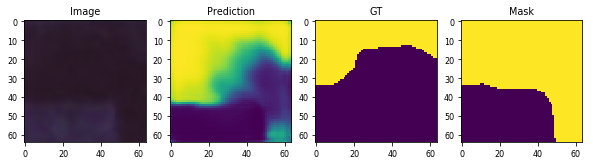

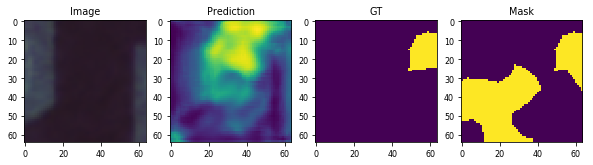

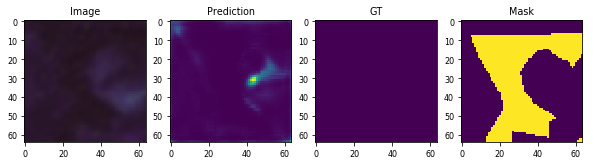

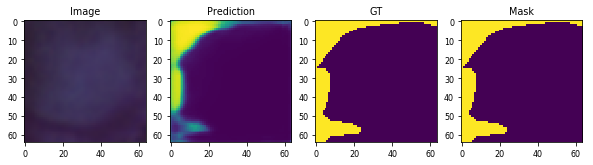

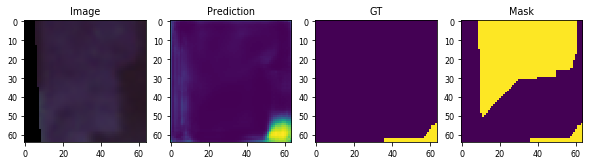

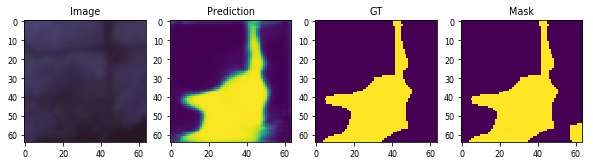

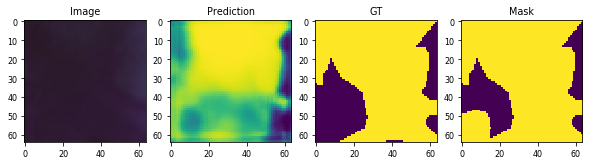

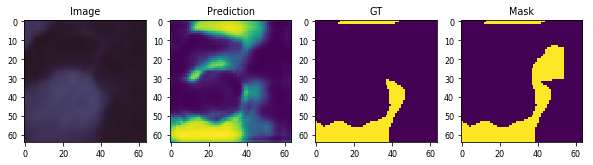

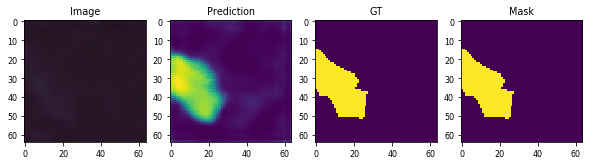

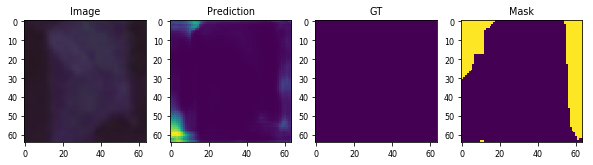

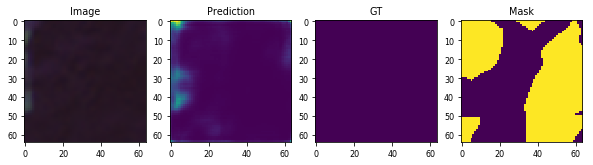

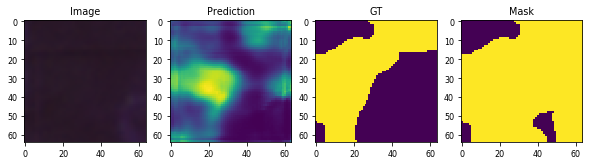

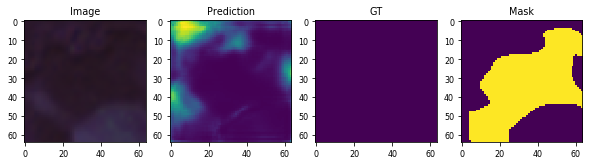

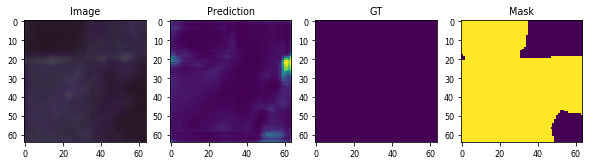

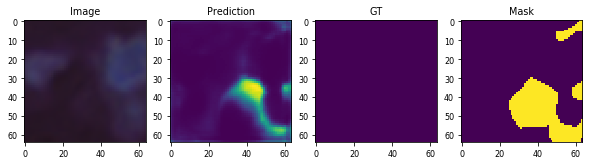

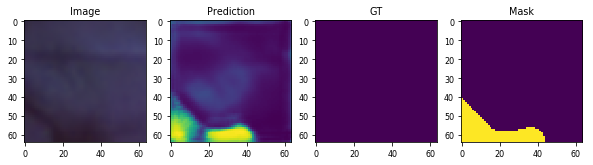

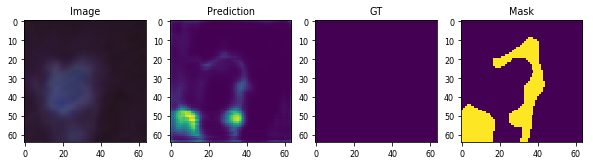

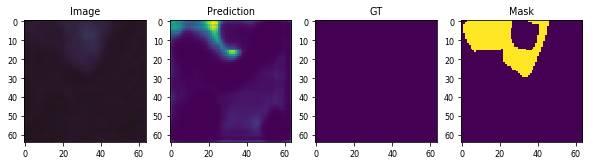

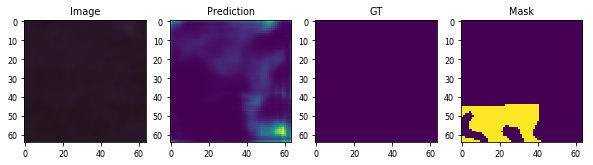

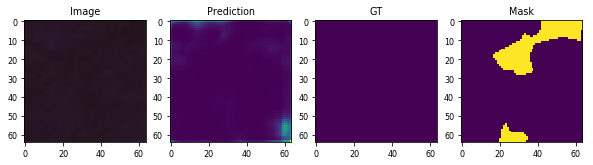

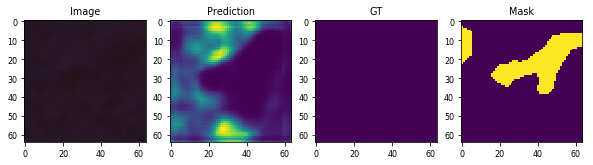

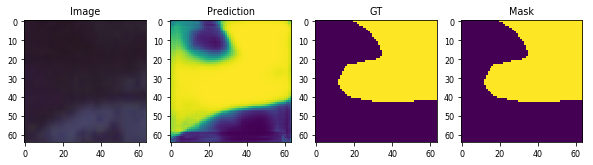

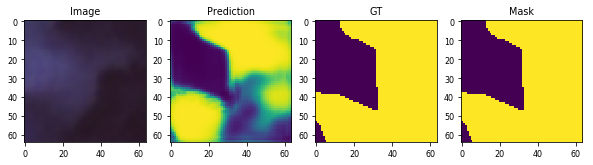

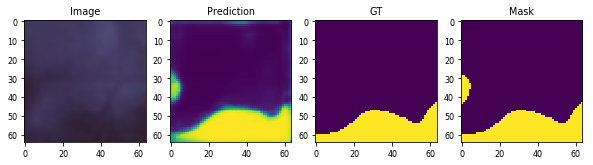

In [151]:
cl=1
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 4, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num, :, :, 2:5])
    a = fig.add_subplot(1, 4, 2)
    a.set_title('Prediction')
    imgplot = plt.imshow(pred[num,:,:,1])#np.where(np.argmax(pred[num,:,:,:], axis=2)==cl, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 4, 3)
    a.set_title('GT')
    imgplot = plt.imshow(mask[num,:,:,cl])

    a = fig.add_subplot(1, 4, 4)
    a.set_title('Mask')
    imgplot = plt.imshow(np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0))

In [13]:
def get_img_mask_array_val(imgpath, num_channels=13, num_classes=2, class_0=['S'], class_1=['E']):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    img = np.ones((size_y, size_x, num_channels), dtype=np.uint8)
    #read channels
    for i in range(num_channels-1-age_flag): 
        i_ch = i + 1
        if i < 9:
            i_ch = '0'+str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            src.read(1, img[:,:,i])
            #img[:,:,-1] = src.read(1)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        src.read(1, img[:,:,-1-age_flag]) 
    img = img.astype(np.float)   
    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(1).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)

    #read classes 
    mask = np.zeros((img.shape[0], img.shape[1], num_classes)) 
    for cl_name in class_0:
        with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
            mask[:,:,0] += src.read(1).astype(np.float)
    
    for cl_name in class_1:
        with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
            mask[:,:,1] += src.read(1).astype(np.float)
               
    mask[:,:,0] = mask[:,:,0] > 0.5
    mask[:,:,1] = mask[:,:,1] > 0.5
    return np.asarray(img), np.asarray(mask)

In [14]:
def metric_4cl(model, num_cl = 2, class_0=['S'], class_1=['E']):
    
    TP = np.zeros((num_cl), dtype=int)
    TN = np.zeros((num_cl), dtype=int)
    FN = np.zeros((num_cl), dtype=int)
    FP = np.zeros((num_cl), dtype=int)
    
    imgarr=[]
    maskarr=[]
    for id_elem in range(len(val_img_list)): #val_img_list
        img,mask=get_img_mask_array_val(val_img_list[id_elem], num_channels=13+age_flag, class_0=class_0, class_1=class_1) #val_img_list
        size_x, size_y, _ = img.shape
        for i in range(0, int(size_x / IMG_ROW)):
            for j in range(0, int(size_y / IMG_COL)):
                imgarr.append(img[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                maskarr.append(mask[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                #forestarr.append(mask_forest[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
    
    imgarr = np.asarray(imgarr)
    #forestarr = np.asarray(forestarr)
    maskarr = np.asarray(maskarr)#*forestarr
    pred = model.predict(imgarr)#*forestarr
    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    accuracy = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))
    
    for cl in range(num_cl):
        gt = np.where(maskarr[:,:,:,cl] == 1, 1, 0) * np.sum(maskarr, axis=3) #np.sum(maskarr, axis=3)
        pr_cl = np.sum(maskarr, axis=3)*np.where(np.argmax(pred, axis=3)==cl, 1, 0)
        TP[cl] += np.sum(pr_cl * gt)
        FP[cl] += np.sum(pr_cl * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
        FN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * gt )
        TN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
    #print(FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['0', '1', '2','4' ]
    for i in range(num_cl):
        print(classes[i], ': precision ', round(precision[i], 5), ' recall ', round(recall[i], 5), ' f1 ', round(f1_cl[i], 5))
        print(' ')
    #return maskarr,pred 

In [35]:
def total_accuracy(model, num_cl = 2):
    
    imgarr=[]
    maskarr=[]
    forestarr=[]
    for id_elem in range(len(val_img_list)): 
        img,mask,mask_forest=get_img_mask_array_val(val_img_list[id_elem])
        size_x, size_y, _ = img.shape
        for i in range(0, int(size_x / IMG_ROW)):
            for j in range(0, int(size_y / IMG_COL)):
                imgarr.append(img[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                maskarr.append(mask[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                #forestarr.append(mask_forest[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
    
    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    pred = model.predict(imgarr)
    
    total_accuracy = np.sum(maskarr*np.where(pred>0.5, 1, 0)) / np.sum(maskarr) 
    print(total_accuracy)

## Aggregated results for test 

In [36]:
test_img_list_from_wv = ['/home/user/data/EO_Browser_images/0/1_0',
'/home/user/data/EO_Browser_images/0/4_3',
'/home/user/data/EO_Browser_images/0/7_6',
'/home/user/data/EO_Browser_images/1/1_0',
'/home/user/data/EO_Browser_images/1/4_3',
'/home/user/data/EO_Browser_images/1/7_6']

In [37]:
def generate_prediction(model): 
    pred_list = []
    full_mask = []
    for DSE in range(len(test_img_list_from_wv)): #val_img_list test_img_list
        imgarr=[]
        maskarr=[]
        
        img,mask=get_img_mask_array_val( test_img_list_from_wv[DSE],num_channels=13+age_flag) #val_img_list
        
        width = img.shape[0]
        height = img.shape[1]
        img_tmp = np.ones((512, 512, img.shape[2]))
        img_tmp[:width,:height,:] = img
        #padding
        img_tmp[width:,:height,:] = np.flip(img, 0)[:512-width,:,:]
        img_tmp[:width,height:,:] = np.flip(img, 1)[:,:512-height,:]
        img_tmp[width:,height:,:] = np.flip(np.flip(img, 1), 0)[:512-width,:512-height,:]
        
        imgarr = np.asarray([img_tmp])
        pred=model.predict(imgarr,verbose=1)
        pred = pred[:, :width,:height,:]
        pred_list.append(pred)
        
    return pred_list 

In [69]:
B_pred=[]
Os_pred=[] 
E_pred=[] 
S_pred=[]

for cl_name in ['B', 'Os', 'E', 'S']:
    # load json and create model
    json_file = open('/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}_versus_all_best.json'.format(cl_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    if cl_name == 'B':
        model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}_versus_all_best.h5".format(cl_name))
    else:
        model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/{}_versus_all.h5".format(cl_name))
    print("Loaded model from disk")
    
    if cl_name == 'B':
        B_pred = generate_prediction(model)
    elif cl_name == 'Os':
        Os_pred = generate_prediction(model)
    elif cl_name == 'E':
        E_pred = generate_prediction(model)
    else:
        S_pred = generate_prediction(model)

Loaded model from disk
1/1 [==============================] - 0s 42ms/step
Loaded model from disk
1/1 [==============================] - 0s 50ms/step
Loaded model from disk
1/1 [==============================] - 0s 52ms/step
Loaded model from disk
1/1 [==============================] - 0s 54ms/step


In [70]:
pred = np.array([np.array(B_pred)[:,:,:,:,0], np.array(Os_pred)[:,:,:,:,0], np.array(E_pred)[:,:,:,:,0], np.array(S_pred)[:,:,:,:,0]])

In [71]:
maskarr = np.zeros((len(test_img_list_from_wv), 500, 382))
for ind, dse_ind in enumerate(test_img_list_from_wv):
    # ground truth
    #forest_mask = tiff.imread(dse_ind + '_class_606.tif')
    tmp_Os = tiff.imread(dse_ind + '_class_Os.tif') 
    tmp_B = tiff.imread(dse_ind + '_class_B.tif') 
    tmp_E = tiff.imread(dse_ind + '_class_E.tif') 
    tmp_S = tiff.imread(dse_ind + '_class_S.tif') 
    
    asp_gt = (tmp_Os > 0.5) #* forest_mask
    birch_gt = (tmp_B > 0.5) #* forest_mask
    sp_gt = (tmp_S > 0.5) #* forest_mask
    p_gt = (tmp_E > 0.5) #* forest_mask
    
    maskarr[ind, :, :] = np.argmax(np.array([birch_gt, asp_gt, sp_gt, p_gt]), axis=0)

In [72]:
average_score = {'aspen':0, 'birch':0, 'spruce':0,'pine':0}
for ind, dse_ind in enumerate(test_img_list_from_wv):
    # ground truth
    #forest_mask = tiff.imread(dse_ind + '_class_606.tif')
    tmp_Os = tiff.imread(dse_ind + '_class_Os.tif') #* forest_mask
    tmp_B = tiff.imread(dse_ind + '_class_B.tif') #* forest_mask
    tmp_E = tiff.imread(dse_ind + '_class_E.tif') #* forest_mask
    tmp_S = tiff.imread(dse_ind + '_class_S.tif') #* forest_mask
    
    asp_gt = (tmp_Os > 0.5) #* forest_mask
    birch_gt = (tmp_B > 0.5) #* forest_mask
    sp_gt = (tmp_E > 0.5) #* forest_mask
    p_gt = (tmp_S > 0.5) #* forest_mask
    
    # prediction
    asp_pr = np.where(np.argmax(np.array([Os_pred[ind][0][:,:,0], B_pred[ind][0][:,:,0], E_pred[ind][0][:,:,0], S_pred[ind][0][:,:,0]]), axis=0)==0, 1, 0) \
        * (asp_gt + birch_gt + sp_gt + p_gt > 0)
    birch_pr = np.where(np.argmax(np.array([B_pred[ind][0][:,:,0], Os_pred[ind][0][:,:,0], E_pred[ind][0][:,:,0], S_pred[ind][0][:,:,0]]), axis=0)==0, 1, 0) \
        * (asp_gt + birch_gt + sp_gt + p_gt > 0)
    sp_pr = np.where(np.argmax(np.array([E_pred[ind][0][:,:,0], B_pred[ind][0][:,:,0], Os_pred[ind][0][:,:,0], S_pred[ind][0][:,:,0]]), axis=0)==0, 1, 0) \
        * (asp_gt + birch_gt + sp_gt + p_gt > 0)
    p_pr = np.where(np.argmax(np.array([S_pred[ind][0][:,:,0], B_pred[ind][0][:,:,0], E_pred[ind][0][:,:,0], Os_pred[ind][0][:,:,0]]), axis=0)==0, 1, 0) \
        * (asp_gt + birch_gt + sp_gt + p_gt > 0)

    num_cl = 4

    TP = np.zeros((num_cl), dtype=int)
    TN = np.zeros((num_cl), dtype=int)
    FN = np.zeros((num_cl), dtype=int)
    FP = np.zeros((num_cl), dtype=int)

    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    accuracy = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))

    gt_list = [asp_pr, birch_pr, sp_pr, p_pr]
    pr_list = [asp_gt, birch_gt, sp_gt, p_gt]
    for cl in range(num_cl):
        gt = gt_list[cl]
        pr_cl = pr_list[cl]
        TP[cl] += np.sum(pr_cl * gt)
        FP[cl] += np.sum(pr_cl * np.where(gt==0, 1, 0)*(asp_gt + birch_gt + sp_gt + p_gt > 0)) #np.sum(maskarr, axis=3))
        FN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * gt )
        TN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * np.where(gt==0, 1, 0)*(asp_gt + birch_gt + sp_gt + p_gt > 0))
    #print(FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['aspen', 'birch', 'spruce','pine' ]
    
    for i in range(num_cl):
        #print(classes[i], ': precision ', round(precision[i], 5), ' recall ', round(recall[i], 5), ' f1 ', round(f1_cl[i], 5))
        #print(' ')
        average_score[classes[i]] += f1_cl[i]
    


In [73]:
for i in range(num_cl):
    print(classes[i], round(average_score[classes[i]] / len(test_img_list_from_wv), 4))
    print(' ')

aspen 0.3958
 
birch 0.5131
 
spruce 0.7608
 
pine 0.846
 


In [66]:
for i in range(num_cl):
    print(classes[i], round(average_score[classes[i]] / len(test_img_list_from_wv), 4))
    print(' ')

aspen 0.5067
 
birch 0.4724
 
spruce 0.5728
 
pine 0.774
 


In [110]:
(0.4684+0.5699+0.7487+0.8807)/4

0.666925